# Your Final Project Title

- Member 1: Caren Chua
- Member 2: Abby Salas 
- Member 3: Courtney Collins
- Member 4: Arggin Avanessian

## Introduction

## Research Question

#### Are more negative comments getting more engagement?

#### What is the optmial time to post to reach the largest audience on this subreddit

## Dataset Description

## Preprocessing

In [3]:
!pip install nltk

In [5]:
!pip install textblob

  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)


In [4]:
!pip install gensim

  Using cached gensim-4.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)


In [5]:
!pip install wordcloud

  Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (455 kB)


In [6]:
# Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora, models
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
df = pd.read_csv('reddit_vm.csv')
print(df.describe())

             score    comms_num       created
count  1602.000000  1602.000000  1.602000e+03
mean      3.686642     1.838951  1.547197e+09
std      29.915671    16.115147  7.099511e+07
min     -12.000000     0.000000  1.389595e+09
25%       1.000000     0.000000  1.554367e+09
50%       1.000000     0.000000  1.569226e+09
75%       3.000000     1.000000  1.584901e+09
max    1187.000000   595.000000  1.640822e+09


In [8]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


## Preprocessing

In [9]:
# Remove duplicates
df = df.drop_duplicates()

In [10]:
# Remove missing rows
df = df.dropna()

In [11]:
# Remove symbols from text data
df['body'] = df['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [12]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
# Remove stop words from text data
stop_words = set(stopwords.words('english'))
df['body'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [14]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
7,Fuck antivaxxing retards,10,g6jkhp,https://www.reddit.com/r/VaccineMyths/comments...,8,1.587663e+09,httpsyoutubezBkVCpbNnkU,2020-04-23 20:23:42
119,biologically possible insert 5G tracker human ...,9,khzpug,https://www.reddit.com/r/VaccineMyths/comments...,9,1.608647e+09,Although dont believe true COVID19 vaccine rec...,2020-12-22 16:19:39
134,dont see reason trust JJ vaccine,0,ocj9ws,https://www.reddit.com/r/VaccineMyths/comments...,4,1.625288e+09,company knew asbestos products aimed mothers b...,2021-07-03 07:57:05
145,Vaccine Survey,0,ak5ziq,https://www.reddit.com/r/VaccineMyths/comments...,5,1.548543e+09,Hi guys wondering could help research project ...,2019-01-27 00:42:09
161,rant please,13,o6nqcm,https://www.reddit.com/r/VaccineMyths/comments...,1,1.624488e+09,sure sub allows need vent need sanity right po...,2021-06-24 01:35:24


## Analysis

In [18]:
# Sentiment Analysis
texts = df['body'].tolist()
tokenized_texts = [text.lower().split() for text in texts]

In [19]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for body text
df['body_sentiment'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [20]:
# Calculate sentiment scores for title
df['title_sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

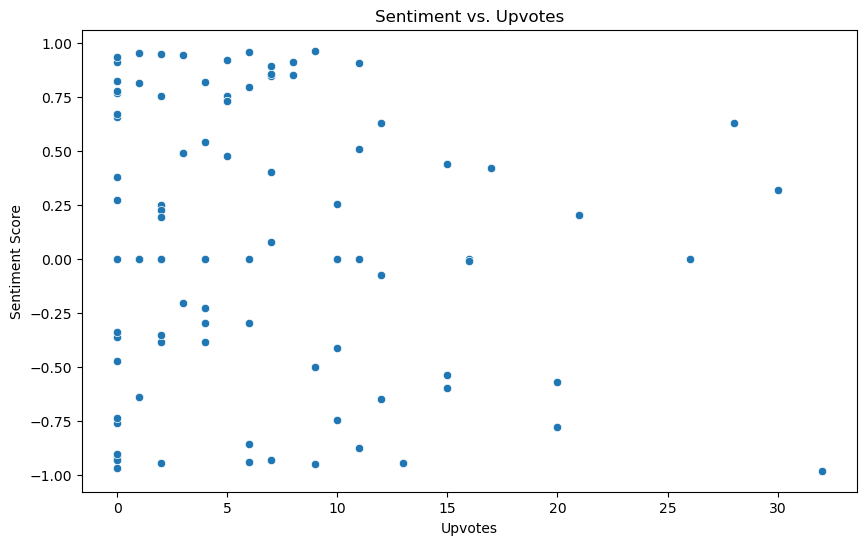

In [22]:
# Visualization: Body Sentiment vs. Upvotes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='score', y='body_sentiment', data=df)
plt.xlabel('Upvotes')
plt.ylabel('Sentiment Score')
plt.title('Sentiment vs. Upvotes')
plt.show()

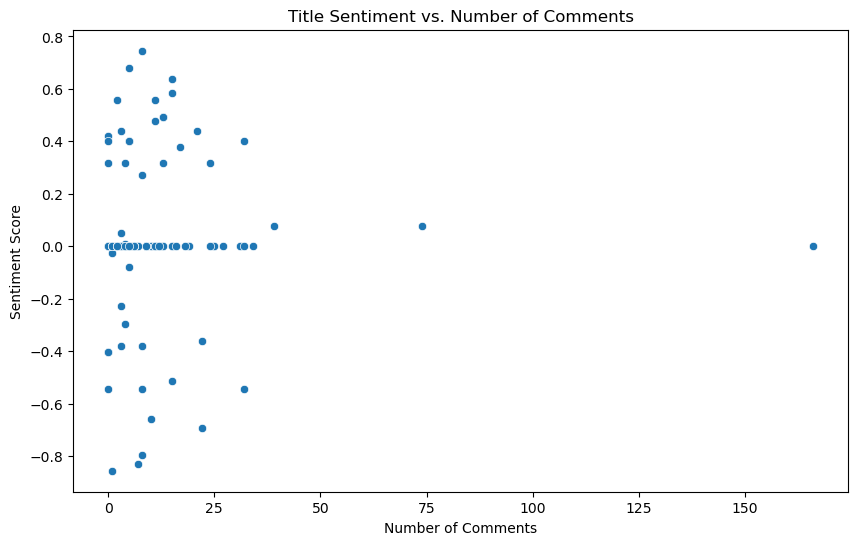

In [74]:
# Visualization: Title Sentiment vs. Upvotes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='comms_num', y='title_sentiment', data=df)
plt.xlabel('Number of Comments')
plt.ylabel('Sentiment Score')
plt.title('Title Sentiment vs. Number of Comments')
plt.show()

In [77]:
df['interaction'] = df['comms_num'] + df['score']

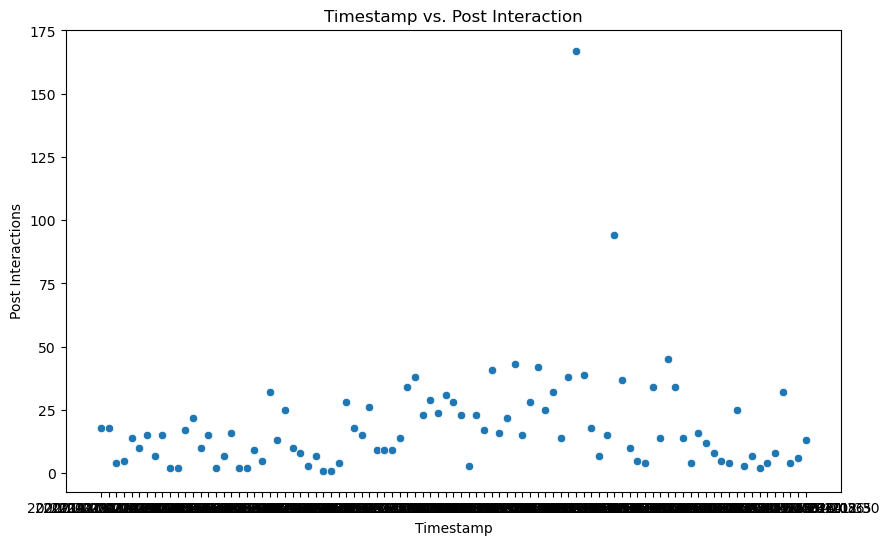

In [79]:
# Visualization: Body Sentiment vs. Upvotes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='timestamp', y='interaction', data=df)
plt.xlabel('Timestamp')
plt.ylabel('Post Interactions')
plt.title('Timestamp vs. Post Interaction')
plt.show()

## Visualization

In [14]:
!pip install bokeh

## Results/Findings

## Contribution